# Face recognition inference pipeline
[source](https://github.com/timesler/facenet-pytorch/blob/master/examples/infer.ipynb)

In [2]:
import os
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from facenet_pytorch import InceptionResnetV1
from fpt.path import FACE

In [3]:
def collate_fn(x):
    return x[0]

In [4]:
# Define variable
workers = 0 if os.name == 'nt' else 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_CATEGORY = "training_aihub_sample"

In [5]:
# Define dataset, dataloader, model
dataset = datasets.ImageFolder(str(FACE / DATA_CATEGORY))
setattr(dataset, "idx_to_class", {i: c for c, i in dataset.class_to_idx.items()})
loader = DataLoader(
    dataset,
    num_workers=workers,
    collate_fn=collate_fn,
)
resnet = InceptionResnetV1(pretrained="vggface2").eval().to(device)

In [6]:
# Preprocess  (6.0s)
idx_to_class = getattr(dataset, 'idx_to_class')
aligned = []
names = []
for x, y in tqdm(loader):
    arr_img = np.array(x.resize([160, 160]), dtype=np.float32)
    img_cropped = torch.from_numpy(arr_img)
    x_aligned = img_cropped.permute([2, 0, 1])
    aligned.append(x_aligned)
    names.append(idx_to_class[y])

100%|██████████| 292/292 [00:05<00:00, 55.17it/s]


In [7]:
# Inference: Embedding  (10.7s)
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

# Visualize

In [9]:
from bisect import bisect_left, bisect_right
import pandas as pd
import seaborn as sns

In [10]:
# Index
target_class = 'F0001-D'
lo, hi = bisect_left(names, target_class), bisect_right(names, target_class)
target_embeddings = embeddings[lo:hi]
target_names = names[lo:hi]

In [11]:
# Euclidean distance
dists = [[(e1 - e2).norm().item() for e2 in target_embeddings] for e1 in target_embeddings]
out = pd.DataFrame(dists, columns=target_names, index=target_names)

<AxesSubplot:>

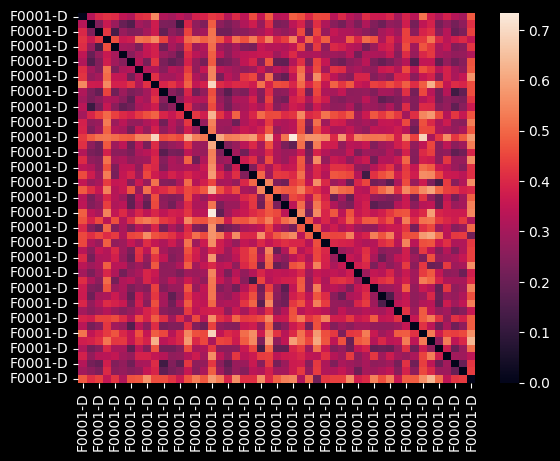

In [12]:
# Heatmap
sns.heatmap(out)